# GANS 
`FIRST MODEL !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!`

## Model Architecture 
<img src="images/Model1_book.png" height=1500  width =1500>

# PREPARING DATA
`Dataset that forms an exponential growth curve`
<ol>
    <li>Create Training Data</li>
    <li>You’ll create pairs of data points (x, y) that
conform to the exponential growth shape.</li>
    <li>Put in batches to feed in network</li>
</ol>

In [30]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.nn import Sequential , Linear , ReLU , Sigmoid , Dropout
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

In [2]:
torch.manual_seed(0)
observations = 2048
train_data = torch.zeros((observations,2))
#fill data 
train_data[:,0]= 50*torch.rand(observations) # random number unifrom distribution 50*(0,1) 2048 times 
train_data[:,1]= 1.08**train_data[:,0] # raises 1.08 to power of corresponding number in first column 


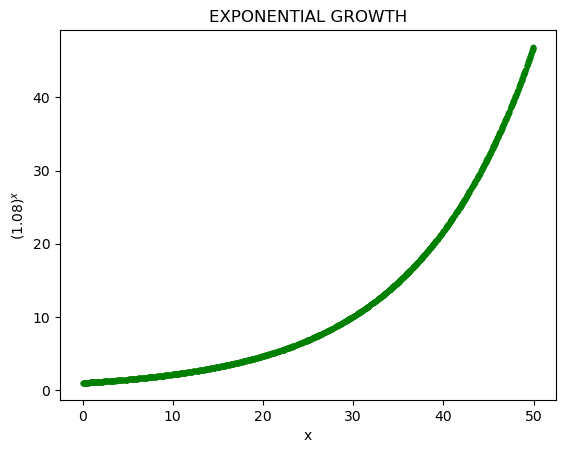

In [3]:
plt.plot(train_data[:,0],train_data[:,1],".",c='g')
plt.xlabel('x')
plt.ylabel('$(1.08)^x$',weight='bold')
plt.title('EXPONENTIAL GROWTH');

In [4]:
# preparing the dataset 
batch_sz = 128 
train_set = DataLoader(train_data,batch_size=batch_sz,shuffle=True)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
discrim = Sequential(
    Linear(2,256),
    ReLU(),
    Dropout(0.3),
    Linear(256,128),
    ReLU(),
    Dropout(0.3),
    Linear(128,64),
    ReLU(),
    Dropout(0.3),
    Linear(64,1),
    Sigmoid()
).to(device)

In [7]:
gen= Sequential(
    Linear(2,16),
    ReLU(),
    Linear(16,32),
    ReLU(),
    Linear(32,2)
).to(device)

In [8]:
loss_fun = nn.BCELoss()
lr =0.0005
optimD = torch.optim.Adam(discrim.parameters(),lr=lr)
optimG = torch.optim.Adam(gen.parameters(),lr=lr)

In [9]:
# performance metrix 
mse = nn.MSELoss()
def performance_metrix(fake_samples):
    real = 1.08**fake_samples[:,0] # column one is the 'x' remember?
    loss = mse(fake_samples[:,1],real) # here column 1 is the values generated by 'gen'
    return loss

class Earlystop:
    def __init__(self,patience=1000):
        self.patience=patience
        self.steps = 0
        self.min_gdif = float('inf')

    def stop(self,gdif):
        if gdif<self.min_gdif:
            self.min_gdif=gdif
            self.steps=0
        elif gdif>=self.min_gdif:
            self.steps+=1
        if self.steps>=self.patience:
            return True
        else: 
            return False

stop=Earlystop()

## TRAINING 

In [10]:
fake_labels = (torch.zeros((batch_sz,1))).to(device)
real_labels =(torch.ones((batch_sz,1))).to(device)

In [11]:
# functions for training 
## training Discriminator on real

def d_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    outD=discrim(real_samples)
    loss_Dr = loss_fun(outD,real_labels)
    loss_Dr.backward()
    optimD.step()
    return loss_Dr

## training D on fake

def d_fake():
    samples = torch.randn((batch_sz,2))
    samples=samples.to(device)
    fake_samples = gen(samples)
    optimD.zero_grad()
    outDf=discrim(fake_samples)
    loss_Df = loss_fun(outDf,fake_labels)
    loss_Df.backward()
    optimD.step()
    return loss_Df

## training generator 

def train_gen():
    noise = torch.randn((batch_sz,2))
    noise = noise.to(device)
    optimG.zero_grad()
    fake_samples = gen(noise)
    out_G=discrim(fake_samples)
    loss_G = loss_fun(out_G,real_labels)
    loss_G.backward()
    optimG.step()
    return loss_G , fake_samples
    

In [12]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%100==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=50)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

at epoch 1, G loss: 0.7411409378051758, D loss 0.8423004786173502


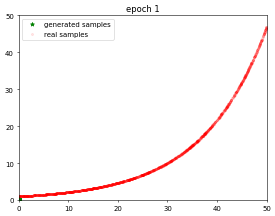

at epoch 100, G loss: 0.9988305409749348, D loss 1.1991625467936198


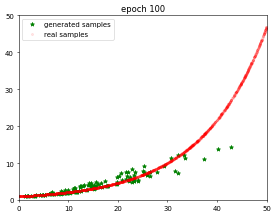

at epoch 200, G loss: 0.7758678436279297, D loss 1.4586196899414063


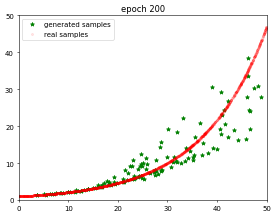

at epoch 300, G loss: 0.7669708251953125, D loss 1.4777482350667317


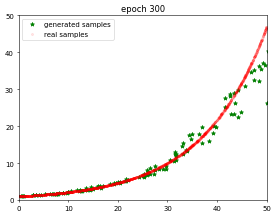

at epoch 400, G loss: 0.7552667617797851, D loss 1.4719401041666667


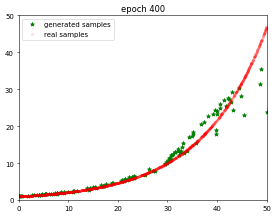

at epoch 500, G loss: 0.7660946528116862, D loss 1.4679819742838542


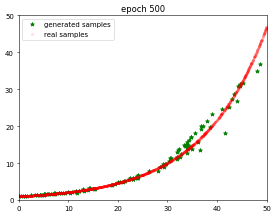

at epoch 600, G loss: 0.7700385411580404, D loss 1.4653030395507813


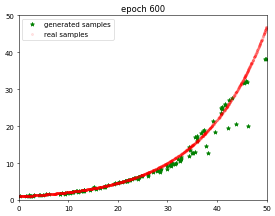

at epoch 700, G loss: 0.7873670578002929, D loss 1.4516635894775392


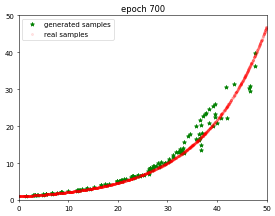

at epoch 800, G loss: 0.804798952738444, D loss 1.439291763305664


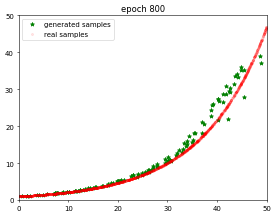

at epoch 900, G loss: 0.801893679300944, D loss 1.4206695556640625


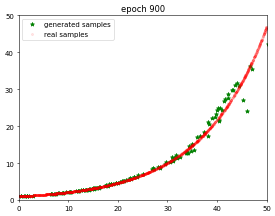

at epoch 1000, G loss: 0.8219972610473633, D loss 1.4042701721191406


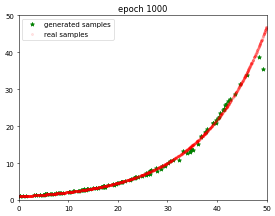

In [13]:
for epoch in range (1000):
    gloss=0
    dloss=0
    for n , real_samples in enumerate(train_set):
        loss_D = d_real(real_samples)
        dloss+=loss_D
        loss_D = d_fake()
        dloss+=loss_D
        loss_g , fake_samples = train_gen()
        gloss+= loss_g
    test_epoch(epoch,gloss,dloss,n,fake_samples)
    gdif=performance_metrix(fake_samples).item()
    if stop.stop(gdif)==True:
        break

In [14]:
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(gen) 
scripted.save('files/exponential.pt') 

In [15]:
new_Gen=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_Gen.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [16]:
noise=torch.randn((batch_sz,2)).to(device)
new_data=new_Gen(noise) 

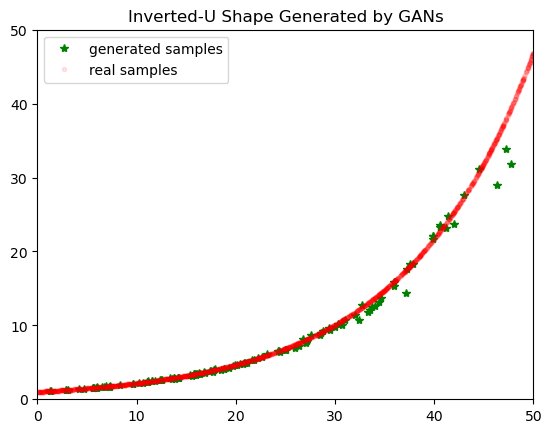

In [17]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()

# Generating numbers with patterns

In [77]:
def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

In [78]:
def int_to_onehot(number):
    onehot=onehot_encoder(number,100)
    return onehot

In [79]:
def gen_seq():
    idxs=torch.randint(0,20,(10,)) # generates 10 random integers with values between 0,20 
    vals= idxs*5
    return vals 

In [80]:
sequence = gen_seq()
print(sequence)

tensor([25, 40, 65, 35, 65, 30, 40, 80,  5, 20])


In [81]:
def gen_batch():
    sequence = gen_seq()
    batch = [int_to_onehot(i).numpy() for i in sequence]
    batch= np.array(batch)
    return torch.tensor(batch)
batch = gen_batch()

In [82]:
def data_to_num(data):
    num=torch.argmax(data,dim=-1)
    return num
numbers = data_to_num(batch)
numbers

tensor([ 0, 60, 90, 55, 75, 30, 20, 55, 90, 35])

In [83]:
# models 
DM = Sequential(
    Linear(100,1),
    Sigmoid()
).to(device)

GR = Sequential(
    Linear(100,100),
    ReLU() # cause the values should be either 0 or 1 
).to(device)

loss_fun = nn.BCELoss() # cuh just discriminate between 0 or 1
lr =0.0005
optimD = torch.optim.Adam(params=DM.parameters(),lr=lr)
optimG = torch.optim.Adam(params=GR.parameters(),lr=lr)

In [84]:
# training 
real_labels = torch.ones((10,1)).to(device)
fake_labels = torch.zeros((10,1)).to(device)

def train_D_G(DM,GR,loss_fn,optimD,optimG):
    #generate example of real data 
    true_data = gen_batch().to(device)
    preds =DM(true_data)
    loss_D1 = loss_fn(preds,real_labels.reshape(10,1))
    optimD.zero_grad()
    loss_D1.backward()
    optimD.step()

    #train on fake data 
    noise = torch.randn(10,100).to(device) # 10 rows of 100 values 
    generated_data = GR(noise)
    preds = DM(generated_data)
    loss_D2 = loss_fn(preds,fake_labels.reshape(10,1))
    optimD.zero_grad()
    loss_D2.backward()
    optimD.step()

    #train Generator 
    noise = torch.randn(10,100).to(device) # creating latemt space 
    generated_data = GR(noise) #feeding 
    preds = DM(generated_data)
    loss_G = loss_fn(preds,real_labels.reshape(10,1))
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return generated_data
    

In [85]:
stop = Earlystop(800)

mse = nn.MSELoss()
def performance_matrix(generated_data):
    nums = data_to_num(generated_data)
    remainders = nums%5
    ten_zeros = torch.zeros((10,)).to(device)
    mseloss = mse(remainders,ten_zeros)
    return mseloss
for i in range(10000):
    gloss =0
    dloss=0
    generated_data=train_D_G(DM,GR,loss_fun,optimD,optimG)
    loss = performance_matrix(generated_data)
    if stop.stop(loss)==True:
        break
    if i%50==0:
        print(data_to_num(generated_data))


tensor([20,  4, 82, 73, 61, 82, 86, 85, 55, 31], device='cuda:0')
tensor([20, 95, 14, 77, 66, 43, 90, 86, 76, 40], device='cuda:0')
tensor([27, 66,  6, 48, 83, 66, 81, 14,  2, 18], device='cuda:0')
tensor([66, 47,  5, 99,  5, 83,  5, 71, 95, 64], device='cuda:0')
tensor([27, 18, 43, 95, 34, 27, 80, 91, 75, 47], device='cuda:0')
tensor([90,  4, 38, 78, 18, 14, 66, 66,  5, 64], device='cuda:0')
tensor([48, 90, 75,  5, 34, 83,  5, 78, 82,  6], device='cuda:0')
tensor([ 5, 92, 27, 80, 90,  4, 86, 82,  5, 81], device='cuda:0')
tensor([80, 80, 90, 47,  1, 95,  5,  1, 80,  1], device='cuda:0')
tensor([75, 82,  5, 64, 47, 78, 75,  4, 47, 86], device='cuda:0')
tensor([ 0,  4, 48, 90, 81, 80, 95,  5, 80, 80], device='cuda:0')
tensor([90,  1, 80, 80, 66, 80, 60, 10, 40, 90], device='cuda:0')
tensor([ 4, 75, 72, 95, 81, 80, 47,  4, 10, 47], device='cuda:0')
tensor([90, 85, 90,  5, 40, 90,  0, 25, 81, 15], device='cuda:0')
tensor([15,  5, 35, 40, 10, 85,  5, 85, 90, 70], device='cuda:0')
tensor([40

In [86]:
# save model 
os.makedirs("files",exist_ok=True)
scripted=torch.jit.script(GR)
scripted.save('files/num_gen.pt')

In [87]:
new_G = torch.jit.load('files/num_gen.pt',map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
)

In [75]:
# obtain inputs from the latent space
torch.manual_seed(42)
noise=torch.randn((10,100)).to(device)
# feed the input to the generator 
new_data=new_G(noise) 
print(data_to_num(new_data))

tensor([75,  0, 75,  0, 55, 50, 50, 25, 15, 15], device='cuda:0')
